In [15]:
import logging
import os

import torch
from torch.utils.data import DataLoader

from drcnet.data import DataSet
from drcnet.fit import fit_model
from drcnet.model import DenoiserNet
from utils import setup_logging

# from utils.checkpoint import load_checkpoint
from utils.data import DBrainDataLoader, StanfordDataLoader

# from utils.metrics import (
#     compare_volumes,
#     compute_metrics,
#     save_metrics,
#     visualize_single_volume,
# )
from utils.utils import load_config

train = False
dataset = "dbrain"
# Setup logging
log_file = setup_logging(log_level=logging.INFO)
logging.info(f"Starting training with dataset: {dataset}")

# Get the directory where this script is located
script_dir = "/home/paco/TechJourney/TechJourney/DWMRI/src/drcnet"
config_path = os.path.join(script_dir, "config.yaml")

logging.info(f"Loading config from: {config_path}")

settings = load_config(config_path)
logging.info("Configuration loaded successfully")

if dataset == "dbrain":
    logging.info("Using DBrain dataset configuration")
    settings = settings.dbrain
    data_loader = DBrainDataLoader(
        nii_path=settings.data.nii_path,
        bvecs_path=settings.data.bvecs_path,
        bvalue=settings.data.bvalue,
        noise_sigma=settings.data.noise_sigma,
    )
    logging.info(
        f"DBrainDataLoader initialized with noise_sigma={settings.data.noise_sigma}"
    )
elif dataset == "stanford":
    logging.info("Using Stanford dataset configuration")
    settings = settings.stanford
    data_loader = StanfordDataLoader(settings.data)
    logging.info("StanfordDataLoader initialized")
else:
    raise ValueError(f"Invalid dataset: {dataset}")

logging.info("Loading data...")
_, noisy_data = data_loader.load_data()
# omitting the b0s from the data
take_volumes = settings.data.num_b0s + settings.data.num_volumes
logging.info(f"Taking volumes from {settings.data.num_b0s} to {take_volumes}")
noisy_data = noisy_data[...,:96, settings.data.num_b0s : take_volumes]
logging.info(f"Noisy data shape: {noisy_data.shape}")
logging.info(
    f"Data type: {noisy_data.dtype}, Min: {noisy_data.min():.4f}, Max: {noisy_data.max():.4f}, Mean: {noisy_data.mean():.4f}"
)

train_set = DataSet(
    noisy_data,
    take_volume_idx=settings.data.take_volume_idx,
    patch_size=(
        settings.data.num_volumes,
        settings.data.patch_size,
        settings.data.patch_size,
        settings.data.patch_size,
    ),
    step=settings.data.step,
)
train_loader = DataLoader(
    train_set, batch_size=settings.train.batch_size, shuffle=True
)
logging.info(
    f"DataLoader created with batch_size={settings.train.batch_size}, num_batches={len(train_loader)}"
)
logging.info("Initializing DenoiserNet model...")
model = DenoiserNet(
    input_channels=settings.model.in_channel,
    output_channels=settings.model.out_channel,
    groups=settings.model.groups,
    dense_convs=settings.model.dense_convs,
    residual=settings.model.residual,
    base_filters=settings.model.base_filters,
    output_shape=(settings.model.out_channel, *noisy_data.shape[:3]),
)
logging.info(
    f"Model initialized - in_channel: {settings.model.in_channel}, out_channel: {settings.model.out_channel}"
)
logging.info(
    f"Total model parameters: {sum(p.numel() for p in model.parameters())}"
)

logging.info("Setting up optimizer and scheduler...")
optimizer = torch.optim.Adam(
    model.parameters(), lr=settings.train.learning_rate
)
logging.info(f"Optimizer: Adam(lr={settings.train.learning_rate})")

scheduler = None
if settings.train.use_scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=settings.train.scheduler_step_size,
        gamma=settings.train.scheduler_gamma,
    )
    logging.info(
        f"Scheduler: StepLR(step_size={settings.train.scheduler_step_size}, "
        f"gamma={settings.train.scheduler_gamma})"
    )

logging.info(f"Training device: {settings.train.device}")
logging.info(f"Number of epochs: {settings.train.num_epochs}")
logging.info(f"Checkpoint directory: {settings.train.checkpoint_dir}")

# setting checkpoint dir taking into account run/model parameters
checkpoint_dir = os.path.join(
    settings.train.checkpoint_dir,
    f"bvalue_{settings.data.bvalue}",
    f"num_volumes_{settings.data.num_volumes}",
    f"noise_sigma_{settings.data.noise_sigma}",
    f"learning_rate_{settings.train.learning_rate}",
)
os.makedirs(checkpoint_dir, exist_ok=True)

# Training
if train:
    fit_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        num_epochs=settings.train.num_epochs,
        device=settings.train.device,
        checkpoint_dir=checkpoint_dir,
    )

    logging.info("Training setup completed successfully")
    logging.info(f"Training completed. Log file: {log_file}")

2025-07-22 09:02:42,212 - root - INFO - Logging configured - level: INFO, file: logs/training_20250722_090242.log
2025-07-22 09:02:42,213 - root - INFO - Starting training with dataset: dbrain
2025-07-22 09:02:42,213 - root - INFO - Loading config from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-07-22 09:02:42,214 - root - INFO - Loading configuration from: /home/paco/TechJourney/TechJourney/DWMRI/src/drcnet/config.yaml
2025-07-22 09:02:42,222 - root - INFO - Configuration file loaded successfully
2025-07-22 09:02:42,223 - root - INFO - Configuration converted to Munch object
2025-07-22 09:02:42,224 - root - INFO - Configuration loaded successfully
2025-07-22 09:02:42,225 - root - INFO - Using DBrain dataset configuration
2025-07-22 09:02:42,225 - root - INFO - DBrainDataLoader initialized - nii_path: /home/paco/d_brain/D_BRAIN_b2500_6_60_14_HCP_nless.nii, bvecs_path: /home/paco/d_brain/D_BRAIN_b2500_6_60_HCP_b_matrix.txt, bvalue: 2500, noise_sigma: 0.01
2025-

In [16]:
from utils.checkpoint import load_checkpoint

logging.info("Reconstructing DWIs...")
best_loss_checkpoint = os.path.join(
            checkpoint_dir, "best_loss_checkpoint.pth"
        )
reconstruct_model = DenoiserNet(
            input_channels=settings.model.in_channel,
            output_channels=settings.model.out_channel,
            groups=settings.model.groups,
            dense_convs=settings.model.dense_convs,
            residual=settings.model.residual,
            base_filters=settings.model.base_filters,
            output_shape=(
                settings.model.out_channel,
                settings.data.take_x,
                settings.data.take_y,
                settings.data.take_z,
            ),
            device=settings.train.device,
        )
reconstruct_model, _, _, _, _ = load_checkpoint(
            model=reconstruct_model,
            optimizer=optimizer,
            filename=best_loss_checkpoint,
            device=settings.reconstruct.device,
        )
reconstruct_noisy_data = noisy_data[:,:,:96,:]
noisy_data_shape = reconstruct_noisy_data.shape
reconstruct_set = DataSet(
            reconstruct_noisy_data,
            take_volume_idx=settings.data.take_volume_idx,
            patch_size=(
                settings.data.num_volumes,
                settings.data.take_x,
                settings.data.take_y,
                settings.data.take_z,
            ),
            step=1,
        )
reconstruct_loader = DataLoader(reconstruct_set, batch_size=1, shuffle=False)

2025-07-22 09:05:47,532 - root - INFO - Reconstructing DWIs...
2025-07-22 09:05:47,533 - root - INFO - Initializing DenoiserNet: input_channels=9, output_channels=1, groups=1, dense_convs=2, residual=True, base_filters=32
2025-07-22 09:05:47,536 - root - INFO - Initializing GatedBlock: x_channels=32, h_channels=32, dense_convs=2, groups=1
2025-07-22 09:05:47,537 - root - INFO - Initializing DenoisingBlock: in_channels=64, inner_channels=32, out_channels=32, inner_convolutions=2, residual=False
2025-07-22 09:05:47,538 - root - INFO - Initializing FactorizedBlock: in_channels=96, out_channels=32, groups=1
2025-07-22 09:05:47,540 - root - INFO - Initializing FactorizedBlock: in_channels=128, out_channels=32, groups=1
2025-07-22 09:05:47,575 - root - INFO - Attempting to load checkpoint from: drcnet/checkpoints/dbrain/bvalue_2500/num_volumes_10/noise_sigma_0.01/learning_rate_0.0001/best_loss_checkpoint.pth
2025-07-22 09:05:47,629 - root - INFO - Checkpoint loaded successfully: drcnet/check

In [23]:
from tqdm import tqdm

device = "cpu"
reconstruct_model.to(device)
reconstruct_model.eval()
with torch.inference_mode():
    for x, _ in tqdm(reconstruct_loader):
        x = x.to(device)
        reconstructed = reconstruct_model(x)
reconstructed = reconstructed.squeeze().detach().cpu().numpy()

    

100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


In [21]:
import numpy as np
reconstructed = np.transpose(reconstructed[None,...], (0,3,1,2))

(1, 96, 128, 128)


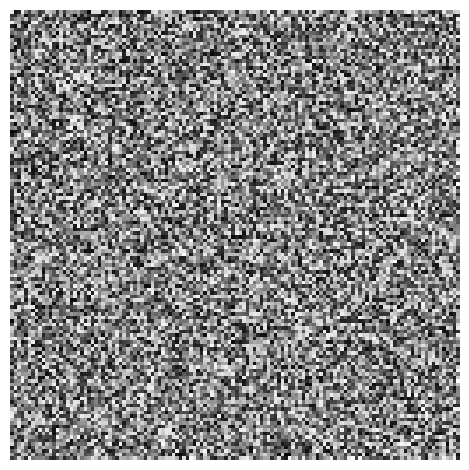

In [22]:
from utils.metrics import visualize_single_volume

visualize_single_volume(
                 reconstructed,
)